In [1]:
%matplotlib inline

import qinfer as qi
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

In [20]:
class DiffusivePrecessionModel(qi.SimplePrecessionModel):
    diffusion_rate = 0.001 # We'll multiply this by
                             # sqrt(time) below.

    def update_timestep(self, modelparams, expparams):
        step_std_dev = self.diffusion_rate * np.sqrt(expparams)
        steps = step_std_dev * np.random.randn(
            modelparams.shape[0], 1, expparams.shape[0]
        )
        
        print("model", modelparams)
        print("exp", expparams)
        
        print("steps", steps)
        # Finally, we add a new axis to the input model parameters
        # to match the experiment parameters.
        return modelparams[:, :, np.newaxis] + steps

In [30]:
modelparams = np.array([[1]])
expparams =  np.array([1])



In [27]:
modelparams.shape[0], 1, expparams.shape[0]

(1, 1, 1)

In [22]:
model = DiffusivePrecessionModel()
prior = qi.UniformDistribution([0, 1])
updater = qi.SMCUpdater(model, 10, prior)

expparams = np.empty((1, ), dtype=model.expparams_dtype)

true_trajectory = []
est_trajectory = []

true_params = prior.sample()

In [23]:
for idx_exp in range(1):
    expparams[0] = np.random.random() * 10 * np.pi
    datum = model.simulate_experiment(true_params, expparams)
    updater.update(datum, expparams)

    true_params = model.update_timestep(true_params, expparams)[:, :, 0]

    true_trajectory.append(true_params[0])
    est_trajectory.append(updater.est_mean())

model [[ 0.84510387]
 [ 0.24262005]
 [ 0.33187104]
 [ 0.61933987]
 [ 0.85557364]
 [ 0.23265793]
 [ 0.59603482]
 [ 0.03884378]
 [ 0.95497046]
 [ 0.55976514]]
exp [ 13.22114977]
steps [[[-0.00429729]]

 [[ 0.00135643]]

 [[-0.00176864]]

 [[ 0.00724147]]

 [[-0.00305596]]

 [[-0.00236042]]

 [[-0.00343435]]

 [[ 0.00230887]]

 [[-0.00838529]]

 [[ 0.00174435]]]
model [[ 0.28522007]]
exp [ 13.22114977]
steps [[[-0.00401021]]]


C:\Program Files\Anaconda3\lib\site-packages\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (6.952140834077406). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


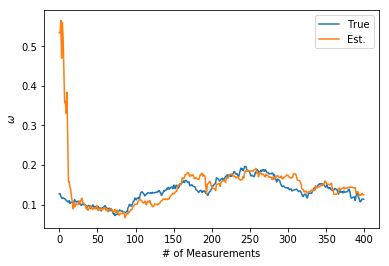

In [5]:
plt.plot(true_trajectory, label='True')
plt.plot(est_trajectory, label='Est.')
plt.legend()
plt.xlabel('# of Measurements')
plt.ylabel(r'$\omega$')

plt.show()

In [509]:
%run nv_sensing_lib.py

In [510]:
class SinusoidalPrecessionModel(qi.SimplePrecessionModel):
    freq_rate = 0.007
    amplitude = 0.02
    
    start = np.array([[0.5]])
    
    @property
    def expparams_dtype(self):
        return [('t', 'float'), ('w_', 'float')]

    def update_timestep(self, modelparams, expparams):
        # Finally, we add a new axis to the input model parameters
        # to match the experiment parameters.
#         return modelparams[:, :, np.newaxis] 

        if modelparams.shape[0] == 1:
            steps = np.ones(  (modelparams.shape[0], 1, expparams.shape[0]) ) * self.amplitude * np.cos(self.freq_rate*expparams[0][0])
            return self.start[:, :, np.newaxis] + steps
        else:
            steps = self.amplitude * self.freq_rate * 2 * np.random.randn(modelparams.shape[0], 1, expparams.shape[0])
            return modelparams[:, :, np.newaxis] + steps

In [511]:
model = SinusoidalPrecessionModel()
prior = qi.UniformDistribution([0.45, 0.55])
updater = qi.SMCUpdater(model, 2000, prior, resample_a=0.92, resample_thresh=0.4)
heuristic = stdPGH(updater, inv_field='w_')   

expparams = np.empty((1, ), dtype=model.expparams_dtype)
experiment = heuristic()

true_params = np.array([[0.5]]) #prior.sample()
brake_sigma = 0.02/100

In [512]:
true_trajectory = []
est_trajectory = []
track_cov = []

for idx_exp in range(2000):
    experiment = heuristic()

    expparams[0][0] = idx_exp
    
    datum = model.simulate_experiment(true_params, experiment)
    updater.update(datum, experiment)

    true_params = model.update_timestep(true_params, expparams)[:, :, 0]
    
    track_cov.append( np.sqrt( updater.est_covariance_mtx() ) )

    true_trajectory.append(true_params[0])
    est_trajectory.append(updater.est_mean())

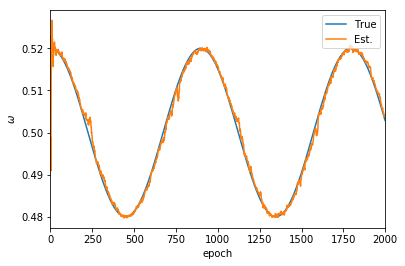

In [513]:
plt.plot(true_trajectory, label='True')
plt.plot(est_trajectory, label='Est.')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel(r'$\omega$')

plt.xlim(0,2000)

plt.show()